# LDA

# Table of Contents
- [Lemmatization](#Lemmatization)
- [Word Cloud - Prompts](#WordCloud-Prompts)
- [LDA - Prompts](#LDA-Prompts)
- [Word Cloud - Answers](#WordCloud-Answers)
- [LDA - Answers](#LDA-Answers)

In [1]:
import pandas as pd
import os

import altair as alt # For visualization
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import re
from collections import Counter
from wordcloud import WordCloud

#Convert Text to a Bag-of-Words Representation
from gensim.corpora.dictionary import Dictionary

#Apply LDA
from gensim.models.ldamodel import LdaModel

#Visualize Topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [2]:
# Read csv file
df = pd.read_csv("combine.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1321 non-null   int64 
 1   RepoName            1321 non-null   object
 2   URL_chatgptsharing  1321 non-null   object
 3   Prompt              1321 non-null   object
 4   Answer              1321 non-null   object
dtypes: int64(1), object(4)
memory usage: 51.7+ KB


,Unnamed: 0,RepoName,URL_chatgptsharing,Prompt,Answer
0,7870,paul-gauthier/aider,https://chat.openai.com/share/4555f0ea-1e7b-49...,How can I setup a github action to automatical...,"Sure, I can certainly help you with that. Here..."
1,7898,chitalian/gptask,https://chat.openai.com/share/902cd378-3ebc-4e...,Give me some test commands for this\n\nimport ...,This Python script is a command-line tool that...
2,7906,bbelderbos/htmx-demo,https://chat.openai.com/share/c8c101fa-aaae-49...,how to get the first 20 rows from a django model?,"To get the first 20 rows from a Django model, ..."
3,7907,bbelderbos/htmx-demo,https://chat.openai.com/share/c8c101fa-aaae-49...,"I have this view for infinite scroll, would be...",Certainly! You can refactor the code to use Dj...
4,7908,bbelderbos/htmx-demo,https://chat.openai.com/share/c8c101fa-aaae-49...,for page 49 this gives:\n\nInternal Server Err...,Certainly! To handle the ValueError when conve...


# Lemmatization

In [3]:
prompt = []
answer = []

for idx, row in df.iterrows(): 
    prompt.append(row['Prompt'])
    answer.append(row['Answer'])

In [4]:
master_prompt = ' '.join(prompt)
master_answer = ' '.join(answer)

In [5]:
# Ensure NLTK resources are downloaded
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
sentences_prompt = nltk.sent_tokenize(master_prompt)
lemmatizer = WordNetLemmatizer()

# Lemmatization
for i in range(len(sentences_prompt)):
    words = nltk.word_tokenize(sentences_prompt[i])
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    sentences_prompt[i] = ' '.join(words)  

text_prompt = "".join(sentences_prompt)

In [7]:
sentences_answer = nltk.sent_tokenize(master_answer)
lemmatizer = WordNetLemmatizer()

# Lemmatization
for i in range(len(sentences_answer)):
    words = nltk.word_tokenize(sentences_answer[i])
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    sentences_answer[i] = ' '.join(words)  

text_answer = "".join(sentences_answer)

# WordCloud-Prompts

Most Common Words:
file: 806
line: 613
i: 390
return: 335
c: 321
none: 309
run: 261
npm: 237
str: 234
code: 234
f: 231
name: 228
error: 210
import: 208
info: 204
def: 198
the: 177
object: 171
using: 168
key: 158
python: 156
false: 153
string: 153
result: 150
v: 150


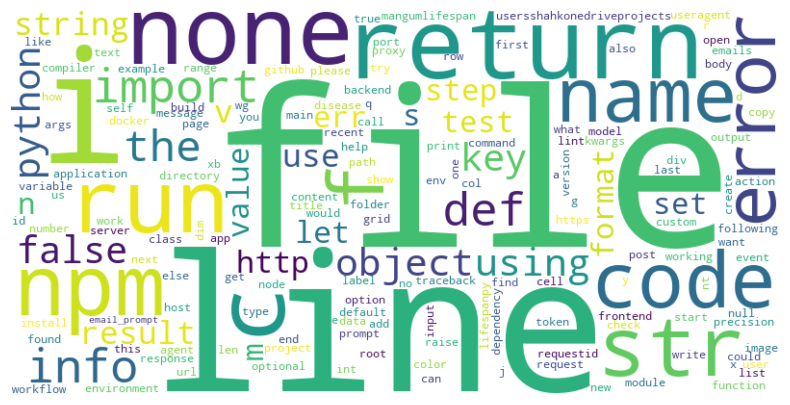

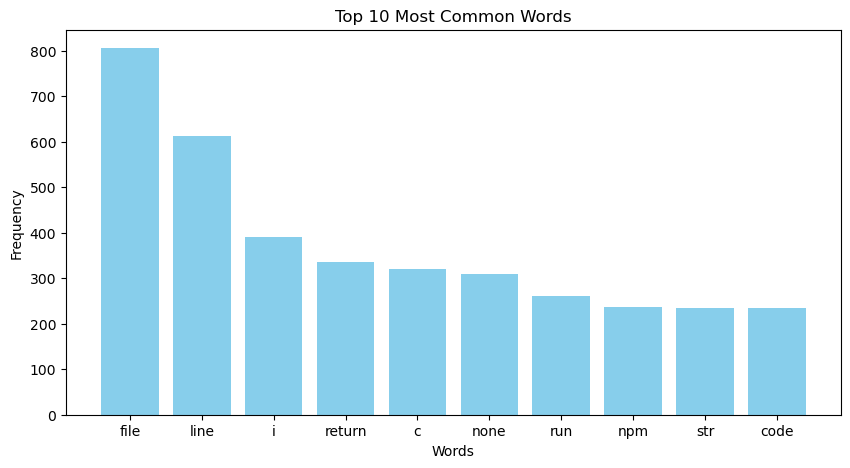

In [8]:
# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()  # Tokenize the text
    return words

# Preprocess and clean the text
words = preprocess_text(text_prompt)

# Count word frequencies
word_counts = Counter(words)

# Display the most common words
print("Most Common Words:")
for word, count in word_counts.most_common(25):
    print(f"{word}: {count}")

# Visualize the results
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Bar Chart
most_common = word_counts.most_common(10)
words, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.title("Top 10 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# LDA-Prompts

In [9]:
# Split the single string into sentences (documents)
documents = sent_tokenize(text_prompt)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text) # Tokenize the text
    return tokens

# Apply preprocessing to each sentence
processed_documents = [preprocess_text(doc) for doc in documents]

# Create dictionary and corpus
dictionary = Dictionary(processed_documents)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]

# Fit LDA model
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=5, 
    random_state=42, 
    passes=10
)

# Display topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}:\n{topic}\n")


Topic 0:
0.026*"file" + 0.024*"line" + 0.015*"none" + 0.012*"info" + 0.010*"false" + 0.010*"str" + 0.008*"c" + 0.008*"q" + 0.007*"return" + 0.007*"result"

Topic 1:
0.018*"file" + 0.014*"npm" + 0.014*"c" + 0.010*"err" + 0.010*"app" + 0.009*"line" + 0.009*"usersshahkonedriveprojects" + 0.008*"i" + 0.008*"test" + 0.007*"import"

Topic 2:
0.019*"i" + 0.011*"let" + 0.007*"step" + 0.006*"j" + 0.006*"e" + 0.006*"v" + 0.006*"dim" + 0.006*"want" + 0.005*"would" + 0.005*"code"

Topic 3:
0.015*"name" + 0.014*"object" + 0.012*"run" + 0.011*"you" + 0.011*"grid" + 0.010*"wg" + 0.010*"return" + 0.010*"cell" + 0.010*"file" + 0.009*"the"

Topic 4:
0.021*"file" + 0.017*"line" + 0.014*"error" + 0.010*"f" + 0.009*"c" + 0.009*"compiler" + 0.008*"return" + 0.007*"import" + 0.007*"prompt" + 0.007*"directory"



In [10]:
# Prepare visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display visualization
pyLDAvis.display(vis)


# WordCloud-Answers

Most Common Words:
file: 2016
s: 1960
code_block_: 1596
this: 1406
code: 1386
using: 1285
the: 1173
directory: 921
function: 895
use: 893
step: 803
command: 780
if: 761
python: 748
project: 689
example: 671
like: 651
specific: 640
run: 639
issue: 639
might: 626
need: 622
test: 618
error: 618
workflow: 603


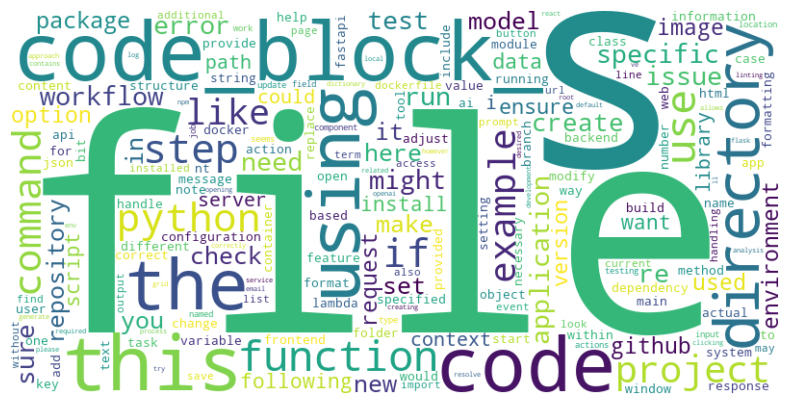

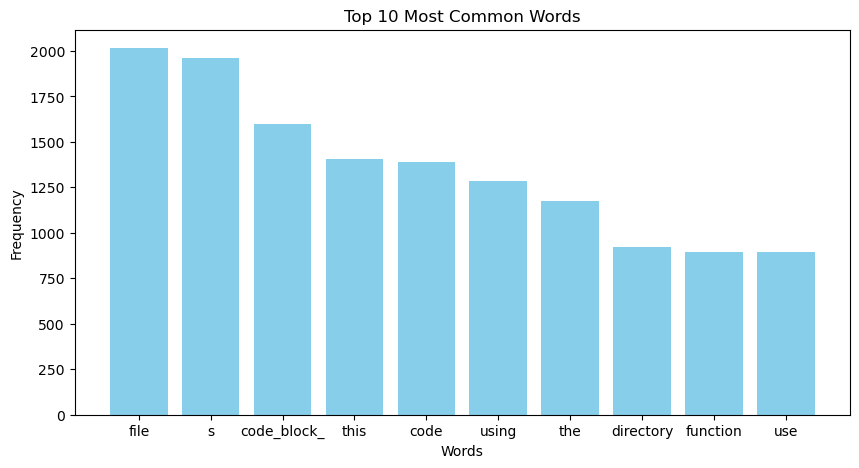

In [11]:
# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()  # Tokenize the text
    return words

# Preprocess and clean the text
words = preprocess_text(text_answer)

# Count word frequencies
word_counts = Counter(words)

# Display the most common words
print("Most Common Words:")
for word, count in word_counts.most_common(25):
    print(f"{word}: {count}")

# Visualize the results
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Bar Chart
most_common = word_counts.most_common(10)
words, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.title("Top 10 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# LDA-Answers

In [12]:
# Split the single string into sentences (documents)
documents = sent_tokenize(text_answer)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text) # Tokenize the text
    return tokens

# Apply preprocessing to each sentence
processed_documents = [preprocess_text(doc) for doc in documents]

# Create dictionary and corpus
dictionary = Dictionary(processed_documents)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]

# Fit LDA model
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=5, 
    random_state=42, 
    passes=10
)

# Display topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}:\n{topic}\n")


Topic 0:
0.017*"file" + 0.012*"using" + 0.009*"s" + 0.008*"code_block_" + 0.008*"application" + 0.007*"window" + 0.007*"this" + 0.007*"new" + 0.007*"like" + 0.007*"code"

Topic 1:
0.016*"s" + 0.014*"code_block_" + 0.012*"file" + 0.011*"repository" + 0.011*"workflow" + 0.011*"this" + 0.010*"github" + 0.010*"use" + 0.009*"the" + 0.009*"code"

Topic 2:
0.012*"function" + 0.009*"s" + 0.009*"code_block_" + 0.008*"script" + 0.008*"grid" + 0.008*"the" + 0.008*"response" + 0.008*"file" + 0.007*"this" + 0.007*"server"

Topic 3:
0.013*"code" + 0.013*"test" + 0.013*"step" + 0.012*"s" + 0.012*"file" + 0.012*"error" + 0.011*"the" + 0.010*"issue" + 0.009*"this" + 0.009*"using"

Topic 4:
0.017*"file" + 0.016*"directory" + 0.016*"s" + 0.013*"code_block_" + 0.011*"code" + 0.011*"this" + 0.010*"command" + 0.008*"using" + 0.008*"function" + 0.007*"project"



In [13]:
# Prepare visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display visualization
pyLDAvis.display(vis)
